# Praca domowa z ML numer 9.

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/Multi_Layer_Perc/homework_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### UWAGA: W poniższym pliku zamieszczono przerywniki tak, aby zapobiec przypadkowemu odpaleniu się funckji, które się bardzo długo liczą (tj. generowanie animacji).

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

#### Funkcje pomocnicze

In [37]:
# funckja służąca do przeskalowania obrazku na różne skale szarości

def rescale_0_1(imgs):
    min_vals = imgs.amin(dim=(1,2,3), keepdim=True)
    max_vals = imgs.amax(dim=(1,2,3), keepdim=True)
    return (imgs - min_vals) / (max_vals - min_vals + 1e-8)

In [38]:
#ustalamy seed
torch.manual_seed(439669)
np.random.seed(439669)

## Trenowanie sieci neuronowej

In [39]:
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [40]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(1*28*28, 1024)
        self.linear2 = torch.nn.Linear(1024, 2048)
        self.linear3 = torch.nn.Linear(2048, 256)
        self.linear4 = torch.nn.Linear(256, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):              # B, 1, 28, 28
        x = self.flatten(x)            # B, 784
        x = self.relu(self.linear1(x)) # B, 1024
        x = self.relu(self.linear2(x)) # B, 2048
        x = self.relu(self.linear3(x)) # B, 256
        x = self.linear4(x)            # B, 10
        x = self.dropout(x)
        return x


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.0001)

net.train() 
for epoch in range(8):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)  

        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean")
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()     
        optimizer.step()    

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3026394844055176
epoch: 0 batch: 1 current batch loss: 2.2641897201538086
epoch: 0 batch: 2 current batch loss: 2.230579137802124
epoch: 0 batch: 3 current batch loss: 2.1910414695739746
epoch: 0 batch: 4 current batch loss: 2.145617723464966
epoch: 0 batch: 5 current batch loss: 2.104902982711792
epoch: 0 batch: 6 current batch loss: 2.0480029582977295
epoch: 0 batch: 7 current batch loss: 2.0022060871124268
epoch: 0 batch: 8 current batch loss: 1.9387311935424805
epoch: 0 batch: 9 current batch loss: 1.8815499544143677
epoch: 0 batch: 10 current batch loss: 1.8103848695755005
epoch: 0 batch: 11 current batch loss: 1.7269233465194702
epoch: 0 batch: 12 current batch loss: 1.6703425645828247
epoch: 0 batch: 13 current batch loss: 1.5714759826660156
epoch: 0 batch: 14 current batch loss: 1.4796439409255981
epoch: 0 batch: 15 current batch loss: 1.4155189990997314
epoch: 0 batch: 16 current batch loss: 1.3261518478393555
epoch: 0 ba

In [42]:
good = 0
wrong = 0

net.eval()     
with torch.no_grad():  
    for batch, data in enumerate(testloader): 
        datapoint, label = data

        prediction = net(datapoint.to(device))                 
        classification = torch.argmax(prediction)  

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9578


In [43]:
#zapisanie do pliku jakby były problemy

torch.save(net.state_dict(), "mlp_model.pth")

### Ładujemy wytrenowany już wcześniej model
######  - jakby były problemy w powyższym kodem to wystarczy pobrać plik pth z githuba

In [44]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(1*28*28, 1024)
        self.linear2 = torch.nn.Linear(1024, 2048)
        self.linear3 = torch.nn.Linear(2048, 256)
        self.linear4 = torch.nn.Linear(256, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):              # B, 1, 28, 28
        x = self.flatten(x)            # B, 784
        x = self.relu(self.linear1(x)) # B, 1024
        x = self.relu(self.linear2(x)) # B, 2048
        x = self.relu(self.linear3(x)) # B, 256
        x = self.linear4(x)            # B, 10
        x = self.dropout(x)
        return x

In [45]:
#korzystamy z cpu lub gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#definiujemy model
net = MLP()

#pobieramy wytenowany model
net.load_state_dict(torch.load("mlp_model.pth"))
net.to(device)

#zamrażamy wagi
net.eval()

MLP(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2048, bias=True)
  (linear3): Linear(in_features=2048, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)

## Część I - neural network dreaming (jedna cyfra)
Poniżej znajduje się kod, który przekształca początkowe obrazki będące szumem (o rozkładzie Gaussa) w obrazy przypominające cyfry ze zbioru danych **MNIST**. Proces ten przebiega poprzez przepuszczenie zaszumionych obrazków przez wcześniej wytrenowaną sieć neuronową, a następnie iteracyjną zmianę wartości pikseli (czyli ich odcieni szarości od białego do czarnego) za pomocą algorytmu *gradient descent*. Celem tej optymalizacji jest uzyskanie obrazków, które sieć rozpozna jako konkretne cyfry z MNIST — mimo że początkowo są to jedynie losowe zakłócenia.

W poniższym kodzie zastosowaliśmy odrazu element regularyzacyjny, to znaczy uwględniliśmy dodatkowo funkcję starty $l_2$, aby wymusić na sieci neuronowej to jak dużo szumu dopuszczamy w finalnym obrazku. Aby to dobrze zobrazować to wybrano następujące $\lambda \in \{0, 0.01, 0.1, 1.0, 10.0\}$, gdzie przypadek $\lambda = 0$ oznacza, że w obliczeniach nie uwględniono czynnika regularyzacyjnego.

In [46]:
lambdas = [0, 0.01, 0.1, 1.0, 10.0]

# ilość kroków, które wykonamy
steps = 7500
#learnin rate
lr = 0.001

In [47]:
# tworzymy listę, która będzie przechowywać obrazki uzyskane dla różnych wartości lambdy
all_images = []

# przechodzimy przez kolejne wartości lambda_l2
for lambda_l2 in lambdas:
    # ustalamy docelowe etykiety od 0 do 9
    targets = torch.arange(10, device=device)

    # inicjalizujemy 10 losowych obrazków (po jednym dla każdej cyfry)
    dr_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

    img_opt = torch.optim.Adam([dr_images], lr=lr)

    # wykonujemy odpowiednią liczbę kroków optymalizacji
    for step in range(steps):
        img_opt.zero_grad()

        # przepuszczamy obrazki przez sieć
        logits = net(dr_images)

        # liczymy stratę: cross-entropy + regularyzacja L2
        loss = F.cross_entropy(logits, targets) + lambda_l2 * dr_images.pow(2).mean()

        loss.backward()
        img_opt.step()

    # przekształcamy obrazki do zakresu [0,1] i przenosimy na CPU
    final_images = rescale_0_1(dr_images.detach().cpu())
    all_images.append((lambda_l2, final_images))

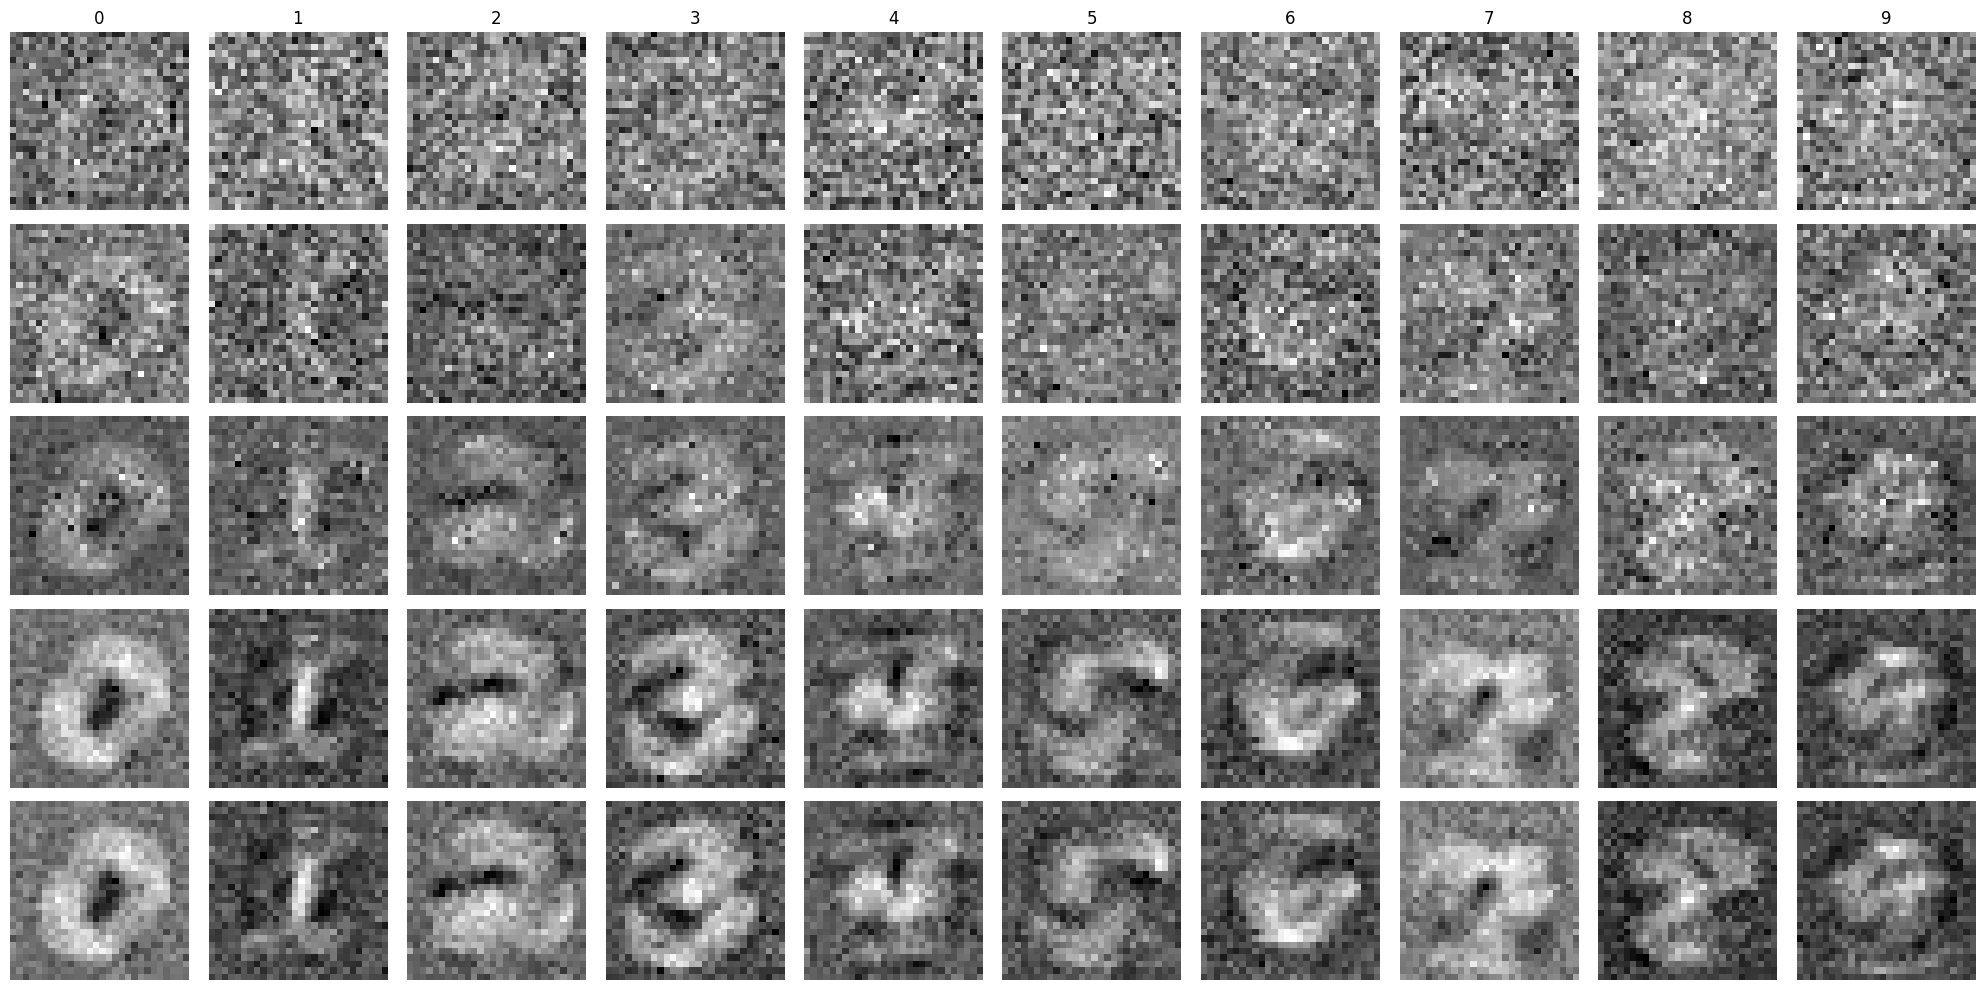

In [48]:
# rysujemy obrazki

fig, axes = plt.subplots(len(lambdas), 10, figsize=(20, 10))
for row_idx, (lambda_val, images) in enumerate(all_images):
    for col_idx in range(10):
        ax = axes[row_idx, col_idx]

        ax.imshow(images[col_idx, 0], cmap='gray')
        if row_idx == 0:
            ax.set_title(f"{col_idx}")

        if col_idx == 0:
            ax.set_ylabel(f"λ={lambda_val:.2e}", rotation=0, labelpad=30)
        ax.axis('off')
plt.tight_layout()
plt.show()

Zauważmy, że w przypadku $\lambda = 0$ cyfry, które otrzymaliśmy w nie przypominają dokładnie cyfr ze zbioru MNIST (chociaż można dostrzec przebijające się szczegóły) - nawet przy przepuszczeniu zaszumionych obrazków ponad 5000 razy przez wytrenowaną wcześniej sieć neuronową. Można wysnuć wniosek, że sieć neuronowa dostrzega jakieś dodatkowe szczegóły, których ludzkie oko być może nie dostrzega wcześniej - oczekujemy pełnej cyfry, aby móc stwierdzić co widać na obrazku. 

Dzieje się tak, ponieważ sieć neuronowa uczy się dodatkowego szumu i małych szczegółów, które pozwalają jej później sklasyfikować dany obrazek jako poszczególna cyfra z dużym przekonaniem.

Warto tutaj również zwrócić uwagę na przypadki gdy dodano czynnik regulryzujący do funckji straty. Mianowicie dodano element `lambda_l2 * dr_images.pow(2).mean()`, który ma kontrolować jak sieć patrzy na szum na obrazku. W szczególności, możemy zauważyć, że wraz ze wzrostem parametru $\lambda_{l2}$ obserwujemy wyostyrzenie się obrazu - dużo lepiej widać na nim cyfry, które chcieliśmy uzyskać. Wynika to z tego, że nakładamy ograniczenie ile szumu chcemy - wysokie $\lambda$ oznacza wyższą karę za dopuszczenie szumu.

Warto również dodać, że cyfry wygenerowany w powyższy sposób są poprawnie klasyfikowane przez sieć neuronową.

Poniżej możemy obejrzeć animację, jak zmieniane są piksele na zaszumionych obrazkach oraz z jakim przekonaniem siec neuronowa klasyfikuje wybraną liczbę. Co ciekawe, wytrenowana sieć neuronowa potrafi sklasyfikować daną cyfrę dużo szybciej niż pojawią się pierwsz większe szczegóły, co widać na animacji.

In [49]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Multi_Layer_Perc/all_lambdas_animation.gif"
HTML(f"<img src='{url}' alt='Animacja dla wszystkich lambda' />")

## Część II – *Neural Network Dreaming* (dwie cyfry)

Poniżej znajduje się kod, który przekształca początkowe obrazki będące szumem (o rozkładzie Gaussa) w obrazy przypominające cyfry ze zbioru danych **MNIST**. Proces ten przebiega poprzez przepuszczenie zaszumionych obrazków przez wcześniej wytrenowaną sieć neuronową, a następnie iteracyjną zmianę wartości pikseli (czyli ich odcieni szarości od białego do czarnego) za pomocą algorytmu *gradient descent*. Celem tej optymalizacji jest uzyskanie obrazków, które sieć rozpozna jako konkretne cyfry z MNIST — mimo że początkowo są to jedynie losowe zakłócenia.

W tej części zadania chcemy jednak uzyskać bardziej złożony efekt: zamiast jednej cyfry, dążymy do wygenerowania obrazka, który będzie przypominał **jednocześnie dwie różne cyfry**. Innymi słowy, modyfikujemy szum w taki sposób, aby po optymalizacji sieć neuronowa rozpoznała na nim zarówno jedną, jak i drugą wybraną cyfrę (mniej więcej - chodzi o to, że prawdopodobieństwa powinny być mniej więcej równe).

Aby osiągnąć ten efekt, modyfikujemy funkcję straty. Zamiast jednej etykiety prawdziwej, rozważamy dwie: pierwotną (`targets`) oraz zamienioną (`targets_changes`). Funkcja straty przyjmuje wówczas postać:

##### `loss = 0.5 * F.cross_entropy(logits, targets) + 0.5 * F.cross_entropy(logits, targets_changes) + lambda_l2 * dr_images.pow(2).mean()`


Idea z taką modyfikacją funkcji straty polega na przypisaniu równych wag dla dwóch różnych etykiet jednocześnie (wagi 0.5) tak aby wymusić minmalizacje funkcji straty w punkcie, gdzie sieć neuronowa sklasyfikuje obrazek jako dwie różne cyfry (z pewną dokładnością.)


W poniższym kodzie zastosowaliśmy odrazu element regularyzacyjny, to znaczy uwględniliśmy dodatkowo funkcję starty $l_2$, aby wymusić na sieci neuronowej to jak dużo szumu dopuszczamy w finalnym obrazku. Aby to dobrze zobrazować to wybrano następujące $\lambda \in \{0, 0.01, 0.1, 1.0, 10.0\}$, gdzie przypadek $\lambda = 0$ oznacza, że w obliczeniach nie uwględniono czynnika regularyzacyjnego.

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_digit = 5        # cyfra, którą animujemy (np. 5)
other_digit = 8         # druga cyfra, do której chcemy się jednocześnie zbliżyć

net.eval()

#Zmienne celu: targets i targets_changes
targets = torch.arange(10, device=device)
targets_changes = targets.clone()
targets_changes[target_digit] = other_digit
targets_changes[other_digit] = target_digit

# Tytuły dla wizualizacji – podmienione cyfry z "&"
titles = [f"{i}" for i in range(10)]
titles[target_digit] = f"{target_digit} & {other_digit}"
titles[other_digit] = f"{other_digit} & {target_digit}"

In [51]:
all_final_images = []

# Pętla po różnych lambda
for lambda_l2 in lambdas:
    dr_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    img_opt = torch.optim.Adam([dr_images], lr=lr)

    for step in range(steps):
        img_opt.zero_grad()
        logits = net(dr_images)
        loss = 0.5 * F.cross_entropy(logits, targets) + \
               0.5 * F.cross_entropy(logits, targets_changes) + \
               lambda_l2 * dr_images.pow(2).mean()
        loss.backward()
        img_opt.step()

    final_images = dr_images.detach().cpu()
    final_images = (final_images - final_images.min()) / (final_images.max() - final_images.min() + 1e-5)
    all_final_images.append(final_images)

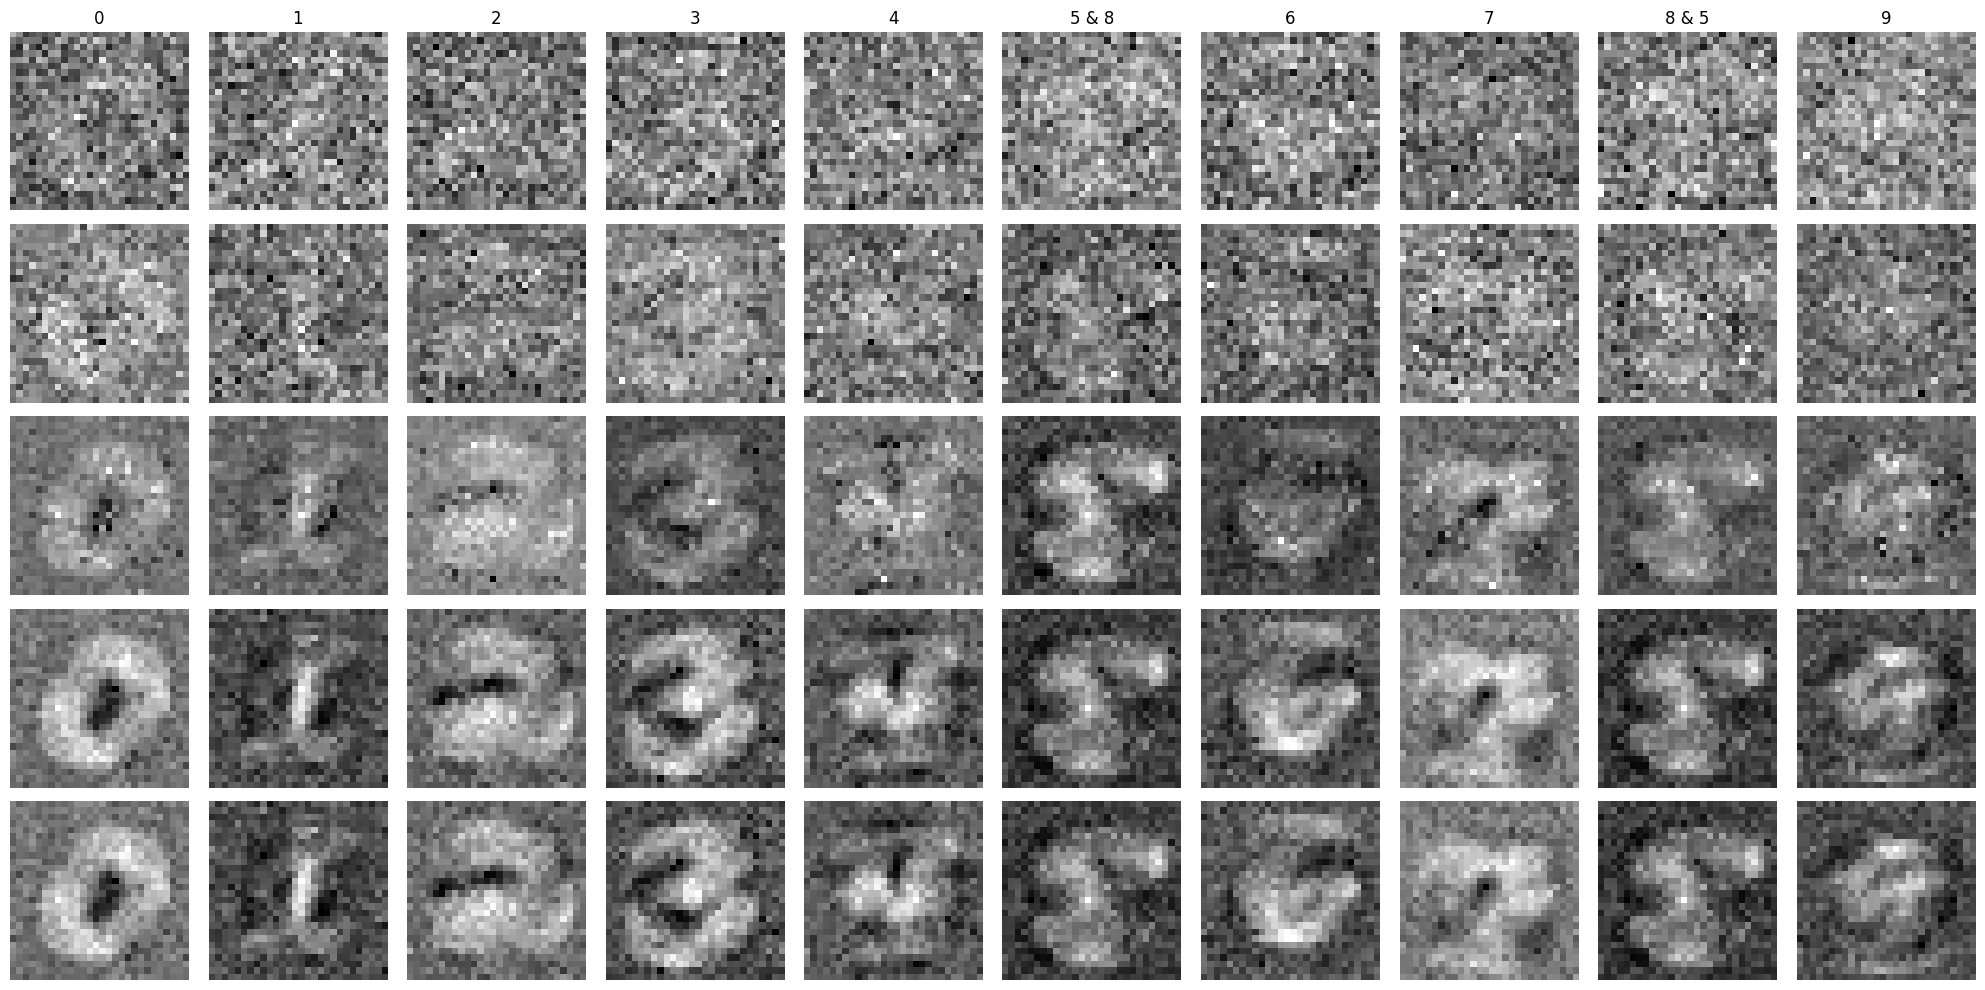

In [52]:
fig, axes = plt.subplots(len(lambdas), 10, figsize=(20, 10))
for row, (lambda_l2, imgs) in enumerate(zip(lambdas, all_final_images)):
    for col in range(10):
        ax = axes[row, col]
        ax.imshow(imgs[col, 0], cmap='gray')
        if row == 0:
            ax.set_title(titles[col])
        ax.axis('off')
    axes[row, 0].set_ylabel(f"λ = {lambda_l2}", rotation=0, labelpad=30, size='large', va='center')

plt.tight_layout()
plt.show()

Jak widać na powyższym obrazku, rzeczywiście na jednym obrazku możemy znaleźć dwie cyfry jednocześnie - chodzi o cyfry 5 i 8. Wobec tego można powiedzieć, że obrana metoda generowania cyfr w sposób jak w poleceniu podziałała. Jak już wspomniano we wcześniejszym zadaniu, wraz ze wzrostem parametru $\lambda$ obserwujemy wzrost jakości obrazu, to znaczy cyfry są dużo lepiej widoczne i przypominają te ze zbioru MNIST. Poniżej możemy obejrzeć animacje, na której pokazane jest jak zmieniają się piksele na zaszumionym obrazku z dwoma liczbami oraz jak wygląda proces klasyfikacji obrazka. Warto tutaj zauważyć, że istotnie prawdopodobieństwo przypisanie dla naszej podówjnej cyfry wartości 5 lub 8 jest zbliżone. Co ciekawe, wytrenowana sieć neuronowa potrafi sklasyfikować daną cyfrę dużo szybciej niż pojawią się pierwsz większe szczegóły, co widać na animacji.

In [53]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Multi_Layer_Perc/double_digit_animation.gif"
HTML(f"<img src='{url}' alt='Animacja dla wszystkich lambda - double digit' />")

In [54]:
raise ValueError("Ta linijka ma na celu zapobieganiu odpalenia animacji, które się bardzo długo liczą")

ValueError: Ta linijka ma na celu zapobieganiu odpalenia animacji, które się bardzo długo liczą

## Animacje

#### Animacja do zadania pierwszego wraz z różnymi parametrami regularyzującymi

In [ ]:
#definiujemy model
net = MLP()

#pobieramy wytenowany model
net.load_state_dict(torch.load("mlp_model.pth"))
net.to(device)

#zamrażamy wagi
net.eval()

In [ ]:
#Konfiguracja
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_digit = 6  # wybrana cyfra, którą będziemy animować
steps = 1501      # liczba kroków optymalizacji
lr = 0.003        # learning rate
lambdas = [0, 0.01, 0.1, 1.0, 10.0]  # lista różnych wartości lambda

#Przygotowanie modelu
net.eval()

#Struktury danych do przechowywania ramek dla każdej lambdy
all_image_frames = []       # lista: dla każdej lambdy -> lista obrazków
all_probability_frames = [] # lista: dla każdej lambdy -> lista prawdopodobieństw

#Optymalizacja osobno dla każdej lambdy
for lambda_l2 in lambdas:
    # tworzymy losowe obrazki i optymalizator
    dr_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    targets = torch.arange(10, device=device)
    optimizer = torch.optim.Adam([dr_images], lr=lr)

    # listy do przechowywania wyników dla tej lambdy
    image_frames = []
    probability_frames = []

    # pętla optymalizacji
    for step in range(steps):
        optimizer.zero_grad()
        logits = net(dr_images)
        loss = F.cross_entropy(logits, targets) + lambda_l2 * dr_images.pow(2).mean()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            img = dr_images[target_digit].detach().cpu().squeeze().numpy()
            img = (img - img.min()) / (img.max() - img.min() + 1e-5)  # skalujemy do [0, 1]
            probs = F.softmax(logits[target_digit], dim=0).cpu().numpy()
            image_frames.append(img)
            probability_frames.append(probs)

    # zapisujemy wyniki do zbiorczych list
    all_image_frames.append(image_frames)
    all_probability_frames.append(probability_frames)

#Przygotowanie wykresu
fig, axes = plt.subplots(len(lambdas), 2, figsize=(10, 10))

def update_all(frame_idx):
    for row_idx in range(len(lambdas)):
        ax_img = axes[row_idx, 0]
        ax_bar = axes[row_idx, 1]

        # czyścimy stare dane
        ax_img.clear()
        ax_bar.clear()

        # pobieramy odpowiednią klatkę z obrazkiem i wykresem słupkowym
        img = all_image_frames[row_idx][frame_idx]
        probs = all_probability_frames[row_idx][frame_idx]

        # obrazek
        ax_img.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax_img.set_title(f"λ={lambdas[row_idx]} | krok {frame_idx}")
        ax_img.axis('off')

        # wykres słupkowy
        ax_bar.bar(np.arange(10), probs)
        ax_bar.set_ylim(0, 1)
        ax_bar.set_title("Prawdopodobieństwo klasyfikacji jako odpowiednia cyfra")
        ax_bar.set_xticks(np.arange(10))

#Tworzymy animację
ani = FuncAnimation(fig, update_all, frames=steps, interval=50)
plt.tight_layout()
ani.save("all_lambdas_animation.gif", writer=PillowWriter(fps=40))
plt.show()

#### Animacja do zadania drugiego wraz z różnymi parametrami regularyzującymi

In [ ]:
#Konfiguracja
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_digit = 5         # cyfra, którą animujemy (np. 5)
other_digit = 8          # druga cyfra, do której chcemy się jednocześnie zbliżyć
steps = 1501      # liczba kroków optymalizacji
lr = 0.005        # learning rate
lambdas = [0, 0.01, 0.1, 1.0, 10.0]  # lista różnych wartości lambda

net.eval()

#Zmienne celu: targets i targets_changes (np. 5 i 8)
targets = torch.arange(10, device=device)
targets_changes = targets.clone()
targets_changes[target_digit] = other_digit
targets_changes[other_digit] = target_digit

all_image_frames = []
all_probability_frames = []

#Pętla po różnych lambdach
for lambda_l2 in lambdas:
    # tworzymy losowe obrazki i optymalizator
    dr_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    optimizer = torch.optim.Adam([dr_images], lr=lr)

    # listy na klatki tej lambdy
    image_frames = []
    probability_frames = []

    # pętla optymalizacji
    for step in range(steps):
        optimizer.zero_grad()
        logits = net(dr_images)
        loss = (
            0.5 * F.cross_entropy(logits, targets)
            + 0.5 * F.cross_entropy(logits, targets_changes)
            + lambda_l2 * dr_images.pow(2).mean()
        )
        loss.backward()
        optimizer.step()

        # zapisujemy klatkę z obrazkiem i softmaxem
        with torch.no_grad():
            img = dr_images[target_digit].detach().cpu().squeeze().numpy()
            img = (img - img.min()) / (img.max() - img.min() + 1e-5)  # skalowanie do [0, 1]
            probs = F.softmax(logits[target_digit], dim=0).cpu().numpy()
            image_frames.append(img)
            probability_frames.append(probs)

    # zapisujemy wyniki dla tej lambdy
    all_image_frames.append(image_frames)
    all_probability_frames.append(probability_frames)

# Przygotowanie wykresów
fig, axes = plt.subplots(len(lambdas), 2, figsize=(10, 2.5 * len(lambdas)))

def update_all(frame_idx):
    for row_idx in range(len(lambdas)):
        ax_img = axes[row_idx, 0]
        ax_bar = axes[row_idx, 1]

        # czyścimy stare dane
        ax_img.clear()
        ax_bar.clear()

        # pobieramy odpowiednie dane
        img = all_image_frames[row_idx][frame_idx]
        probs = all_probability_frames[row_idx][frame_idx]

        # obrazek
        ax_img.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax_img.set_title(f"λ={lambdas[row_idx]} | krok {frame_idx}")
        ax_img.axis('off')

        # wykres słupkowy
        ax_bar.bar(np.arange(10), probs)
        ax_bar.set_ylim(0, 1)
        ax_bar.set_title("Prawdopodobieństwo klasyfikacji jako odpowiednia cyfra")
        ax_bar.set_xticks(np.arange(10))

#Tworzymy animację
ani = FuncAnimation(fig, update_all, frames=steps, interval=50)
plt.tight_layout()

# Zapis do pliku
ani.save("double_digit_animation.gif", writer=PillowWriter(fps=40))
plt.show()
